# Imports


In [1]:
import pandas as pd 
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.cuda.is_available()

True

In [4]:
from dataprep_utils import create_OM_datastore,read_multiple_households_df,OMCondDataset
from torch.utils.data import DataLoader
hdf = create_OM_datastore(hdf_file='../../data/private-2021-2022-openMeterCond.h5')
number_ids = len(hdf.keys())-1
df = read_multiple_households_df(hdf.keys().remove('/16aa1678-a581-4dfa-a91e-17f48bdfd4d3'),hdf)
hdf.close()
train_dataset = OMCondDataset(df,96)

train_loader = DataLoader(dataset=train_dataset,
                        batch_size=9, shuffle=True,drop_last=True)


FileNotFoundError: ``/home/npopkov/syndatagenerators/data/private-2021-2022-openMeterCond.h5`` does not exist

In [ ]:
hdf = create_OM_datastore(hdf_file='../../data/private-2021-2022-openMeterCond.h5')
keys = hdf.keys()
keys.remove("/16aa1678-a581-4dfa-a91e-17f48bdfd4d3")
print(keys)

['/00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d', '/00f8ec53-2c1c-4eeb-a159-5f4881907a72', '/0252a8f5-9913-47bb-a70f-c86e5c69f71a', '/0320fee3-66fb-4f70-b139-ff45d4e03a17', '/0358067f-cd41-4d91-ba9e-91405fbfc704', '/03b8c76b-aee3-473e-8f25-c21cea1e0ba6', '/04b1dc78-587d-4837-978e-ac288a2b480c', '/04b810f1-7117-4dd3-8fc1-1845877daf63', '/0520f1fd-30d5-4ffe-8c57-35c36615586c', '/06d1421b-265b-4a13-a39f-6df00dbf92a6', '/079761e9-7cff-4a34-9039-31a95ae670ea', '/08a12b61-04d9-456c-9312-f20abc713e35', '/0987b42a-c841-4454-90ac-69e5b1054cd5', '/0ab2b2e6-1a39-46c5-bc67-0a635875e03b', '/0cc0fcd7-ba31-4b36-abd6-a59b9700918c', '/0ceb32a7-a1ab-4a67-9d24-af9bdae31c11', '/0d1df061-d516-455b-9194-4b515a2a94af', '/0de28587-2941-47f6-9555-b4456ab5ae9c', '/0e3bc76d-f700-4f37-b09c-60de4f2fd8e7', '/0e642415-2f53-443d-8c86-d0a4863cfedf', '/0ffa64b2-77bd-4ff9-b1c0-125bd6f541ef', '/111893ca-bbac-4269-a2d0-67e9864b3c47', '/1178737b-13d0-4f18-be37-485975448f37', '/12481948-7808-4615-84f7-a0d92eeaf1a2', '/126327a9-1748

In [ ]:
test = train_dataset.samples.flatten()
test.shape

torch.Size([30687456])

torch.Size([9, 96])


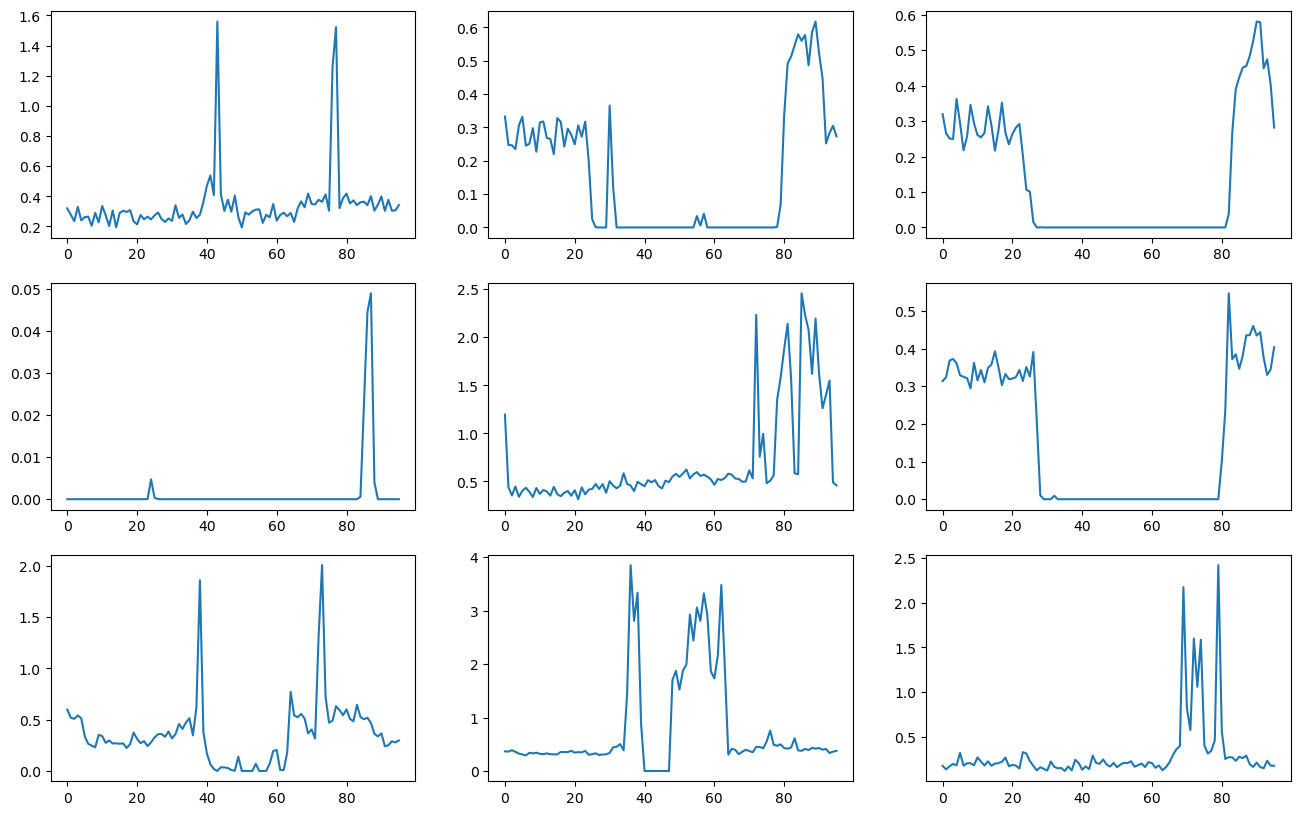

In [ ]:
fig = plt.figure(figsize=(16, 10))
columns = 3
rows = 3
label,cont,x = next(iter(train_loader))
print(x.shape)
for i,img in enumerate(x):
    fig.add_subplot(rows, columns, i+1)
    plt.plot(img.squeeze())
plt.show()

In [ ]:
import torch
import torch.nn as nn
class TaskEmbedding(nn.Module):
    """Embed a single categorical predictor
    
    Keyword Arguments:
    
    num_output_classes: int
    num_cat_classes: list[int]
    num_cont: int
    embedding_dim: int
    hidden_dim: int
    """
    def __init__(self, num_output_classes:int, num_cat_classes:list[int], num_cont:int, embedding_dim:int=64, hidden_dim:int=64):
        super().__init__()
        # Create an embedding for each categorical input
        self.embeddings = nn.ModuleList([nn.Embedding(nc, embedding_dim) for nc in num_cat_classes])
        self.fc1 = nn.Linear(in_features=len(num_cat_classes) * embedding_dim, out_features=hidden_dim) 
        self.fc2 = nn.Linear(in_features=num_cont, out_features=hidden_dim) 
        self.relu = nn.ReLU()
        self.out = nn.Linear(2*hidden_dim, num_output_classes) 
        
    def forward(self, x_cat, x_con):
        # Embed each of the categorical variables
        x_embed = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x_embed = torch.cat(x_embed, dim=1)
        x = self.fc1(x_embed) 
        x_con = self.fc2(x_con) 
        x = torch.cat([x_con, x.squeeze()], dim=1) 
        x = self.relu(x)
        return self.out(x)    

In [ ]:
cat_count = len(df['sensor_id'].unique())
cat,cont,x = next(iter(train_loader))
cont = cont[:,0,:].float()
cat = cat[:,0,:].long()


task_emb = TaskEmbedding(256,train_dataset.lens_cat_conditions,train_dataset.num_cont) 
test = task_emb(cat,cont)

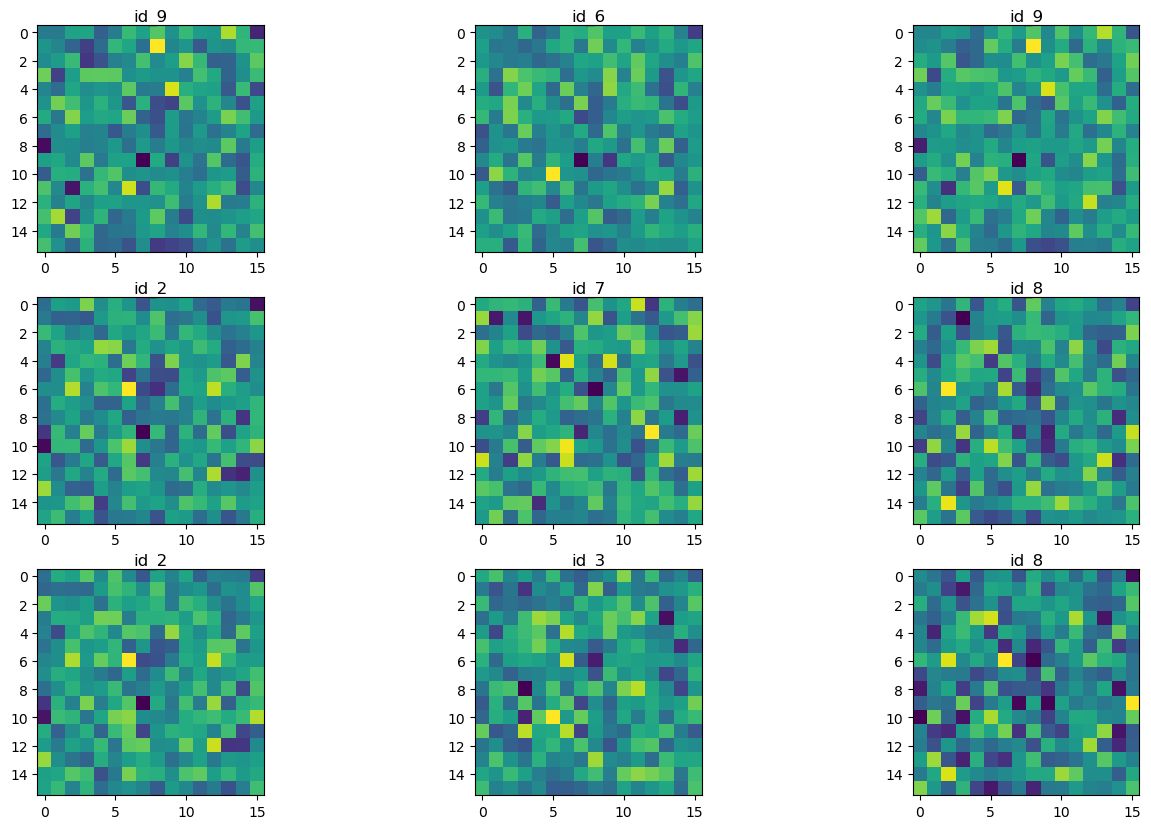

In [ ]:
fig = plt.figure(figsize=(16, 10))
columns = 3
rows = 3
for i,img in enumerate(test):
    fig.add_subplot(rows, columns, i+1)
    plt.title(f"id_{cat[i][0].item()}",pad=.3)
    plt.imshow(img.reshape(-1,16).detach().numpy())
plt.show()
# for i,img in enumerate(test):
#     fig.add_subplot(rows, columns, i+1)
#     plt.plot(img[0].detach().numpy())
# plt.show()

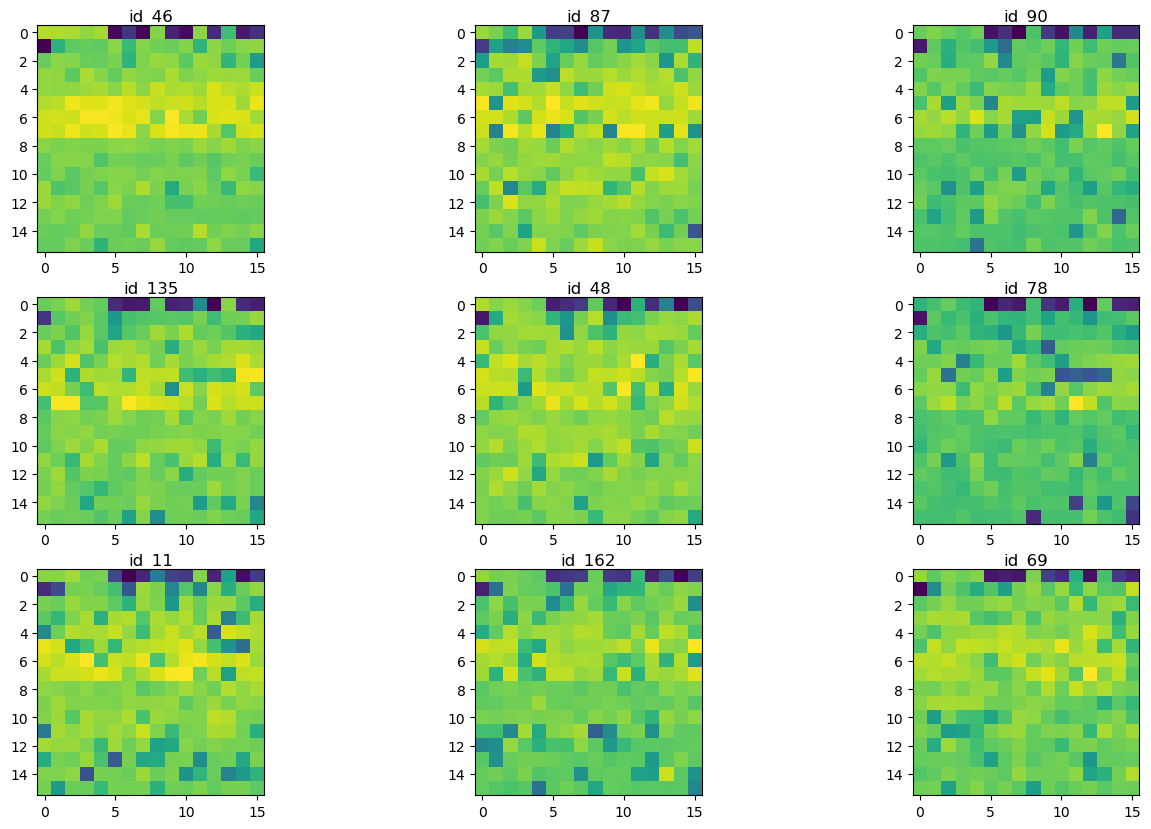

In [ ]:
from syndatagenerators.models.ddpm.utils import loadModel

net_path = "../../../models/MultiHousehold/2023-07-17-2356-200-32-1e-06-0.02-50_net.pt"
trainedEmb = TaskEmbedding(256,[cat_count],5)

loadModel(trainedEmb,net_path)

test2 = trainedEmb(cat,cont)

fig = plt.figure(figsize=(16, 10))
columns = 3
rows = 3
for i,img in enumerate(test2):
    fig.add_subplot(rows, columns, i+1)
    plt.title(f"id_{cat[i].item()}",pad=.3)
    plt.imshow(img.reshape(-1,16).detach().numpy())
plt.show()
# for i,img in enumerate(test):
#     fig.add_subplot(rows, columns, i+1)
#     plt.plot(img[0].detach().numpy())
# plt.show()